# Textual analysis of "The Secret History"

## Import packages

In [1]:
!pip install vaderSentiment
!pip install nltk
!pip install stanza

In [2]:
import requests
import re
from tqdm import tqdm
import os
from os.path import basename
import string
import operator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from os.path import join

import nltk
import nltk
nltk.download('vader_lexicon', quiet=False)

nltk.download('stopwords')

from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

stopwords = stopwords.words('english')

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
ana = SentimentIntensityAnalyzer()


import warnings
warnings.filterwarnings("ignore")


import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('wordnet')
nltk.download('sentiwordnet')

def remove_punctuation(words):
    new_list= []
    for w in words:
        if w.isalnum():
            new_list.append( w )
    return new_list

def ptb_to_wordnet(PTT):

    if PTT.startswith('J'):
        ## Adjective
        return 'a'
    elif PTT.startswith('V'):
        ## Verb
        return 'v'
    elif PTT.startswith('N') and not PTT.startswith('NNP'):
        ## Noune
        return 'n'
    elif PTT.startswith('R'):
        ## Adverb
        return 'r'
    else:
        return ''

def wordnet_hypernyms(token):
    all_hypernyms = []

    word_senses = wn.synsets(token)

    hypernyms = lambda s: s.hypernyms()

    for ws in word_senses:

        hypernyms = [hyp.name() for hyp in list(ws.closure(hypernyms))]
        for h in hypernyms:
            all_hypernyms.append(h[0:h.index('.')])

    return all_hypernyms

def intersection(list1,list2):
    return list(set(list1) & set(list2))


def collocation( text , regex , distance ):

    freq_c = dict()

    sentences = sent_tokenize( text )

    for sentence in sentences:

        words = word_tokenize( sentence )
        words = remove_punctuation(words)

        for i,w in enumerate(words):
            if re.search( regex , w , re.IGNORECASE ):
                index_regex = i 

                for x in range( i - distance , i + distance ):
                    if x >= 0 and x < len(words) and words[x].lower() != words[index_regex].lower():
                        if len(words[x]) > 0:
                            word = words[x].lower()
                            freq_c[ word ] = freq_c.get( word , 0 ) + 1
            
    return freq_c


def download(url):
    response = requests.get(url)
    if response:
        file_name = basename(url)
        out = open(file_name,'w',encoding='utf-8')
        out.write(response.text)
        out.close()
        
text_url = 'https://raw.githubusercontent.com/peterverhaar/dark_academia/refs/heads/main/corpus/secret_history.txt'
download(text_url)

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1091)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1091)>
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package wordne

## Create a lemmatised version of the book

In [3]:
lemmatiser = WordNetLemmatizer()


with open('secret_history.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    lemmatised = ''
    words = word_tokenize(full_text)
    words = remove_punctuation(words)
    pos = nltk.pos_tag(words)

    for i,word in enumerate(words):

        wn_pos = ptb_to_wordnet( pos[i][1] )

        if re.search( r'\w+' , wn_pos , re.IGNORECASE ):
            lemma = lemmatiser.lemmatize( words[i] , wn_pos )
            lemmatised += f' {lemma.lower()} '
                
        else:
            lemmatised += f' {word.lower()}' 
            
with open('secret_history_lemmatised.txt','w',encoding='utf-8') as out:
    out.write(lemmatised)
            

## Create an XML version with chapter divisions

In [4]:
with open('secret_history.xml','w',encoding='utf-8') as out:
    out.write('<novel>\n<div>')
    sections = re.split('\n',full_text)
    
    for section in sections:
        if re.search('(Chapter)|(Prologue)|(Epilogue)',section):
            out.write('</div>\n<div>')
            out.write('<title>')
            section = re.sub('\^','',str(section))
            out.write(section.strip())
            out.write('</title>')
        else:
            out.write(section)
    out.write('</div>\n</novel>')

## Most frequent words

In [5]:
freq = Counter()

with open('secret_history_lemmatised.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    
words = word_tokenize(full_text)
words = remove_punctuation(words)
words = [word for word in words if word not in stopwords]
freq = Counter(words)
    
for word,count in freq.most_common(50):
    print(f'{word} ({count})')

say (2889)
go (1004)
henry (967)
know (953)
think (841)
look (692)
one (689)
get (686)
like (654)
francis (636)
would (584)
back (568)
bunny (525)
charles (523)
see (498)
could (474)
come (472)
time (410)
thing (389)
us (377)
make (376)
take (372)
tell (360)
even (341)
around (330)
way (328)
want (324)
something (322)
room (321)
camilla (298)
hand (291)
much (289)
find (275)
night (268)
eye (268)
door (261)
long (259)
good (254)
julian (253)
little (249)
talk (247)
leave (240)
turn (240)
seem (239)
try (230)
never (225)
day (225)
saw (224)
old (224)
light (218)


## Most frequent adjectives, adverbs, nouns

In [6]:
relevant_tags = ['JJ','JJR','JJS','NN','NNS','RB','RBR','RBS']
black_list = ['i','julian','francis','henry','charles','camilla','corcoran']

data = []

with open('secret_history_lemmatised.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = remove_punctuation(words)
        pos_tags = nltk.pos_tag(words)
        for word_code in pos_tags:
            if word_code[1] in relevant_tags and word_code[0] not in black_list:
                row = []
                row.append(word_code[0])
                row.append(word_code[1])
                data.append(row)

words = pd.DataFrame(data,columns=['word','code'])


In [7]:
adjectives = words.query( f'(code=="JJR") or (code=="JJS") or (code=="JJ")' )
adjectives_freq = Counter( adjectives['word'].tolist() )

for word,count in adjectives_freq.most_common(50):
    print(f'{word} ({count})')

good (245)
little (239)
old (224)
much (185)
other (178)
last (173)
long (171)
bunny (164)
first (163)
bad (140)
more (139)
own (133)
black (112)
big (103)
new (102)
such (102)
open (101)
white (98)
few (96)
dark (92)
hard (92)
right (88)
sure (87)
greek (86)
next (81)
great (79)
same (79)
many (78)
terrible (67)
only (66)
hampden (64)
red (63)
dead (62)
able (61)
light (60)
small (57)
wrong (57)
empty (56)
second (56)
full (54)
least (52)
sudden (52)
most (51)
large (51)
strange (51)
late (51)
clear (50)
high (49)
certain (48)
different (48)


In [8]:
adverbs = words.query( f'(code=="RB") or (code=="RBR") or (code=="RBS")' )
adverbs_freq = Counter( adverbs['word'].tolist() )

for word,count in adverbs_freq.most_common(50):
    print(f'{word} ({count})')

not (800)
there (464)
then (454)
so (433)
back (419)
just (359)
even (341)
too (315)
very (287)
now (283)
never (225)
here (224)
only (224)
still (203)
well (198)
really (192)
again (178)
quite (159)
more (153)
as (149)
away (134)
up (131)
always (119)
almost (108)
once (106)
much (103)
rather (103)
far (97)
finally (96)
ever (95)
down (91)
suddenly (89)
long (85)
maybe (83)
pretty (70)
most (68)
else (67)
later (63)
perhaps (60)
sometimes (58)
actually (57)
close (57)
right (57)
certainly (56)
alone (56)
also (54)
enough (54)
slightly (49)
already (48)
nearly (48)


In [9]:
nouns = words.query( f'(code=="NN") or (code=="NNS")' )
nouns_freq = Counter( nouns['word'].tolist() )

for word,count in nouns_freq.most_common(50):
    print(f'{word} ({count})')

time (410)
thing (389)
way (328)
something (322)
room (321)
hand (291)
night (268)
eye (268)
door (258)
bunny (256)
day (225)
anything (214)
look (213)
people (208)
moment (181)
face (181)
head (173)
car (167)
house (161)
glass (159)
home (151)
voice (147)
cigarette (147)
place (141)
year (140)
window (140)
course (139)
school (134)
kind (132)
morning (127)
book (124)
lot (124)
nothing (122)
hair (118)
sort (118)
table (116)
man (114)
hour (114)
name (108)
bed (108)
light (107)
chair (101)
everything (97)
life (96)
afternoon (95)
paper (94)
hampden (93)
friend (92)
twin (92)
minute (91)


## Which adjectives are used to describe 'educational institutions'?

In [10]:
school_words = []

with open('secret_history.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    words = word_tokenize(full_text)
    for word in words:
        if 'educational_institution' in wordnet_hypernyms(word) or 'educator' in wordnet_hypernyms(word):
            school_words.append(word.lower())

school_words = list(set(school_words))
print('Educational institutions:')
print(school_words)

school_words = [f'({token})' for token in school_words]

regex = '|'.join(school_words)

print('\nWords used in the context:')
freq = collocation(full_text,regex,5)
sorted_freq = sorted(freq.items(), key=operator.itemgetter(1),reverse=True)

for word,count in sorted_freq:
    if word not in stopwords:
        print(word)    

Educational institutions:
['teachers', 'tutors', 'cyril', 'professors', 'teacher', 'academics', 'instructor', 'lyceum', 'headmaster', 'school', 'academic', 'academy', 'tutor', 'schools', 'kindergarten', 'seminary', 'professor']

Words used in the context:
back
high
said
would
went
one
money
could
every
got
college
little
years
way
expensive
get
well
like
time
prep
hampden
gone
drive
two
go
cloke
even
day
next
morning
near
greek
think
dr
another
week
grade
night
last
really
away
julian
brooklyn
know
early
circumstances
private
summers
switzerland
boston
always
light
piano
wrote
french
named
ancient
speak
rather
basis
difficult
school
job
psychology
lounge
take
give
perhaps
refer
good
thought
stairs
couple
first
weeks
together
far
began
monotone
nursery
finishes
closed
ended
staying
started
henry
afternoon
came
term
old
rayburn
parents
england
sort
us
walked
coming
ceramics
may
someone
camilla
preparatory
decided
leave
everyone
classics
new
door
especially
bunny
say
learned
hours
standin

## Find sentences containing synonyms of the word 'dark'

In [11]:
synonyms = []

for ss in wn.synsets('dark'):
    synonyms.extend(ss.lemma_names())
    
synonyms = list(set(synonyms))
print(synonyms)

['darkness', 'black', 'sour', 'iniquity', 'dismal', 'benighted', 'nighttime', 'sinister', 'non-white', 'obscure', 'sorry', 'disconsolate', 'blue', 'colored', 'shadow', 'wickedness', 'dark-skinned', 'sullen', 'dingy', 'night', 'drear', 'dark', 'drab', 'glowering', 'moody', 'dreary', 'grim', 'saturnine', 'gloomy', 'dour', 'morose', 'coloured', 'glum']


In [12]:
freq = Counter()
total_nr_words = 0

with open('secret_history.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        total_nr_words += len(words)
        if len(intersection(words,synonyms))>0:
            freq.update( intersection(words,synonyms) )
            sentence = re.sub('\n+',' ',sentence)
            print(sentence)

This was a tale that told itself simply and well: the loose rocks, the body at the bottom of the ravine with a clean break in the neck, and the muddy skidmarks of dug-in heels pointing the way down; a hiking accident, no more, no less, and it might have been left at that, at quiet tears and a small funeral, had it not been for the snow that fell that night; it covered him without a trace, and ten days later, when the thaw finally came, the state troopers and the FBI and the searchers from the town all saw that they had been walking back and forth over his body until the snow above it was packed down like ice.
It is difficult to believe that such an uproar took place over an act for which I was partially responsible, even more difficult to believe I could have walked through it – the cameras, the uniforms, the black crowds sprinkled over Mount Cataract like ants in a sugar bowl – without incurring a blink of suspicion.
Now the searchers have departed, and life has grown quiet around me,

I couldn't see much but a Dantesque mass of bodies on the dance floor and a cloud of smoke hovering near the ceiling, but I could see, where light from the corridor spilled into the darkness, an upturned glass here, a wide lipsticked laughing mouth there.
As parties go, this was a nasty one and getting worse – already certain of the freshmen had begun to throw up as they waited in dismal lines for the bathroom – but it was Friday and I'd spent all week reading and I didn't care.
Having been to every Friday night party since school began, I knew they avoided them like the Black Death.
How does his girlfriend get all those black eyes?
With my luck it could only be Judy Poovey, trying to hit up on me as she inevitably did about this time every Friday night.
'Like some security guards handing out a girl on a stretcher and a black dog attacking some hippies.'
The night wind in my hair, their indistinct talk, the songs on the radio all mingled and blurred in my dreams.
It was dark and I co

Finally I asked him about it one night, and he said you were.
That night, as I was lying on my bed reading Greek, I was startled by a flash of remembrance, almost as if a hidden spotlight had been trained without warning on my face.
There was the harsh Ar at the beginning, which called up gold, idols, lost cities in the jungle, which in turn led to the hushed and sinister chamber of Gen, with the bright interrogative Tina at the end – all nonsense, of course, but then it seemed in some muddled way that the name itself, one of the few concrete facts available to me, might itself be a cryptogram or clue.
hurtling towards the bizarre Argentina of my imagination through the dark skies.
I put down my book and went over and sat in a chair by the window, and didn't work for the rest of the night.
Slowly, I climbed the stairs, feet moving, mind oddly blank – the way I'd felt as a kid on Christmas morning when, after a night of almost insane excitement, I would walk down the hall to the closed 

But strange and marvelous as she was, a wisp of silk in a forest of black wool, she was not the fragile creature one would have her seem.
She was the Queen who finished out the suit of dark Jacks, dark King, and Joker.
'And when you get lonesome in the middle of the night?'
Not infrequently he refused to answer his door, even late at night when a light was burning and I knew he was at home; more than once he appeared late for dinner with wet shoes, and windblown hair, and mud on the cuffs of his neat dark trousers.
But now to my astonishment I saw Henry – black suit, umbrella and all – among the celestial maps and unicorns.
On a Thursday night, around twelve-thirty, I was in my pajamas and attempting to cut my own hair with the aid of a mirror and some nail scissors (I never did a very good job; the finished product was always very thistly and childish, a la Arthur Rimbaud) when there was a knock at the door.
Good night.'
It was a Friday afternoon, no class, and I hadn't been out of m

I was walking home that night, paying no attention to where I was going, when a large, sulky fellow approached me near the apple trees in front of Putnam House.
Finally, I struggled to my feet – there was a sharp pain in my ribs, but nothing seemed broken – and limped home in the dark.
I lay there for a while, blinking in the bright sun, as confused details of the previous night floated back to me like a dream; then I reached for my watch on the night table and saw that it was late, almost noon, and why had no one been by to get me?
Most startling of all, a splendid dark cartoon of a black eye was stamped in a ring on my eye socket, in the richest inks of Tyrian, chartreuse, and plum.
(Henry had caught a glimpse of her once – dark glasses, full-length marten coat – clicking rapidly down the stairs of the Lyceum with her bodyguards at her heels.)
I don't know if it's the records per se that have made them curious, or if it was something Cloke himself had said when he talked to them; bu

It was a resemblance they tried to cultivate especially Mrs Corcoran, with her hairdo and faux-Jackie glasses – but it also had some slight physical basis: in Brady and Patrick's toothy, too-tanned gauntness there was a shadow of Bobby Kennedy while the other brothers, Bunny among them, were built on the Ted Kennedy model, much heavier, with little round features bunched in the middle of their faces.
And maybe it was these old associations which were clicking around in my mind or maybe it was that the only funerals I had ever seen were televised events, affairs of state: in any case, the funeral procession-long, black, rain-splashed cars, Mr Vanderfeller's Benrley among them – was linked for me in dreamlike fashion to another funeral and another, far more famous motorcade.
Patrick offered her an arm and she slipped a gloved hand in the crook of his elbow, inscrutable behind her dark glasses, calm as a bride.
Bun, I thought, oh, Bun, I'm sorry.
The pallbearers stood in a dark row behin

I spent the night on Dr Roland's couch, and after breakfast, came back to my room with blueberry muffins and a half-gallon carton of orange juice which, with extraordinary difficulty, I had managed to steal from the buffet in the dining hall.
From the state of the bedclothes, which were tumbled and tossed, blanket trailing on the floor and the stained ticking of the mattress showing where he'd pulled the sheets loose, I gathered he'd not had a very good night of it.
The rest of the Kosher wine had disappeared, I noticed, in the night.
I thought it was Francis or Henry – both of whom I'd tried to reach repeatedly the night before – or maybe even Camilla, but it was Charles.
You'll find it in the drawer of my night table.
I too am very sorry that he is dead.
Afraid of the dark.'
He went to the night table and got the bottle.
We smiled and waved back, happy day, two guys on a ride – then drove for a block or two in grim, superstitious silence.
It rained all day and the rest of the night.


In [13]:
for word,count in freq.most_common():
    print(f'{word} ({count})')

night (240)
dark (161)
black (106)
blue (42)
sorry (41)
darkness (12)
colored (9)
shadow (9)
sour (7)
obscure (6)
gloomy (6)
grim (5)
sullen (5)
dreary (4)
moody (3)
drab (2)
sinister (2)
glum (2)
dismal (1)
disconsolate (1)
morose (1)


In [14]:
print( f'{(sum(freq.values())/total_nr_words)*100}% of the words in the novel are a synponym of "dark"')

0.26756687160009013% of the words in the novel are a synponym of "dark"


## Clothing

References to tweed jackets?

In [15]:
freq = Counter()

with open('secret_history_lemmatised.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    words = word_tokenize(full_text)
    
relevant_categories =  ['clothing','fabric']
    
for word in words:
    hypernyms = wordnet_hypernyms(word)
    if len(intersection(hypernyms,relevant_categories))>0:
        freq.update([word])

for word,count in freq.most_common(50):
    print(f'{word} ({count})')


felt (116)
coat (46)
clothes (43)
dress (41)
suit (36)
shirt (33)
tie (31)
jacket (29)
bathrobe (23)
trouser (16)
hat (16)
overcoat (16)
sweater (12)
sail (12)
scarf (11)
tweed (9)
sock (9)
wrap (9)
cap (8)
handkerchief (8)
pajama (7)
robe (7)
mac (7)
silk (6)
towel (6)
necktie (5)
wool (5)
jean (5)
costume (5)
rag (5)
chiton (5)
mack (5)
velvet (4)
linen (4)
laundry (4)
knit (4)
slicker (4)
royal (3)
canvas (3)
woolen (3)
undershirt (3)
pillbox (3)
khaki (3)
suspender (3)
uniform (2)
greatcoat (2)
cashmere (2)
veil (2)
stole (2)
flannel (2)


## Substances

In [16]:
freq = Counter()

with open('secret_history_lemmatised.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    words = word_tokenize(full_text)
    
relevant_categories =  ['narcotic','drug']
    
for word in words:
    hypernyms = wordnet_hypernyms(word)
    if len(intersection(hypernyms,relevant_categories))>0:
        freq.update([word])

for word,count in freq.most_common(50):
    print(f'{word} ({count})')


cigarette (148)
beer (37)
whiskey (34)
wine (22)
aspirin (9)
liquor (9)
sour (8)
cocktail (7)
champagne (6)
cocaine (6)
martini (5)
bitter (5)
alcohol (5)
sens (5)
cigarettes (4)
brandy (4)
cigar (4)
gin (4)
cure (4)
tylenol (4)
antibiotic (4)
meth (4)
painkiller (4)
vodka (3)
dose (3)
demerol (3)
dope (3)
margaritas (3)
dalmane (3)
sling (2)
rum (2)
booze (2)
ale (2)
valium (2)
narcotic (2)
lsd (2)
antidote (2)
tequila (2)
amphetamine (2)
brew (2)
reefer (1)
shag (1)
cocktails (1)
stout (1)
chloroformed (1)
hypnotic (1)
codeine (1)
cordial (1)
phenobarbital (1)
beaujolais (1)


## Lexicon

In [17]:
dir = 'Lexicon'
if not os.path.isdir(dir):
    os.mkdir(dir)
    
base_url = 'https://raw.githubusercontent.com/peterverhaar/dark_academia/refs/heads/main/Lexicon/'

lexicon_files = [
    'academia.txt',
    'literature_and_culture.txt',
    'mood.txt',
    'objects.txt',
    'spaces.txt'
]
    

for l in lexicon_files:
    topic = l[ : l.rindex('.') ]
    response = requests.get( base_url + l)
    words = []
    if response:
        response.encoding = 'utf-8'
        out = open( os.path.join( dir , l ) , 'w' , encoding = 'utf-8' )
        out.write( response.text )
        out.close()

print('Lexicons have been downloaded!')



lexicons = dict()


for file in os.listdir(dir):
    if re.search(r'txt$',file):
    
        topic = re.sub( r'\.txt$','',file )
        words = []

        with open( join(dir,file) , encoding = 'utf-8' ) as file_handler:   
            for l in file_handler: 
                if re.search( r'\w' , l ):
                    words.append(l.strip().lower())

        lexicons[topic] = words    


Lexicons have been downloaded!


In [18]:
import os
from os.path import join

from nltk.stem import WordNetLemmatizer


csv = open( 'lexicon.csv' , 'w' , encoding = 'utf-8' )

## print header
csv.write('category,count\n')


with open('secret_history_lemmatised.txt',encoding='utf-8') as fh:
    
    lemmatised = fh.read()                
    words = word_tokenize(lemmatised)
    words = remove_punctuation(words)
    freq = Counter(words)
    tokens = len(lemmatised)

    for l in lexicons:
        print(f'{l} ...')   
        csv.write(f'{l},')

        count_occurrences = 0
        for word in l:
            count_occurrences += freq.get(word.lower(),0)
        csv.write( f'{ count_occurrences / tokens}\n' )

    csv.write('\n')

csv.close()

print("Done!")



mood ...
spaces ...
literature_and_culture ...
academia ...
objects ...
Done!


In [19]:


words = []
with open('secret_history_lemmatised.txt',encoding='utf-8') as fh:
    
    lemmatised = fh.read()                
    words = word_tokenize(lemmatised)
    words = remove_punctuation(words)
    
for l in lexicons:
    lexicon_freq = Counter()
    print(f'\n{l}')   
    for word in words:
        if word.lower() in lexicons[l]:
            lexicon_freq.update([word])
    for word,count in lexicon_freq.most_common(20):
        print(f"{word} ({count})")
   



mood
time (410)
dark (166)
silence (77)
past (58)
death (55)
blood (50)
shadow (34)
whisper (33)
silent (32)
murder (29)
funeral (26)
memory (24)
sad (20)
scream (17)
dawn (16)
secret (15)
ghost (15)
mystery (15)
history (14)
twilight (12)

spaces
house (161)
office (87)
college (72)
library (42)
campus (29)
church (18)
faculty (16)
corridor (12)
ruin (12)
tower (8)
dormitory (5)
estate (4)
castle (1)
university (1)
cathedral (1)

literature_and_culture
greek (115)
ancient (22)
rome (17)
plato (14)
classics (9)
latin (9)
homer (9)
fate (5)
dionysus (5)
poetry (4)
philosophy (3)
iliad (3)
tragedy (3)
virgil (2)
verse (2)
sophocles (1)
apollo (1)
oracle (1)
classicism (1)
mythology (1)

academia
course (139)
book (124)
college (72)
student (70)
study (49)
library (42)
term (40)
teacher (35)
campus (29)
learn (26)
dean (25)
teach (24)
literature (19)
freshman (19)
grade (17)
board (17)
reading (17)
faculty (16)
science (13)
examine (13)

objects
cigarette (148)
window (145)
paper (94)
sm

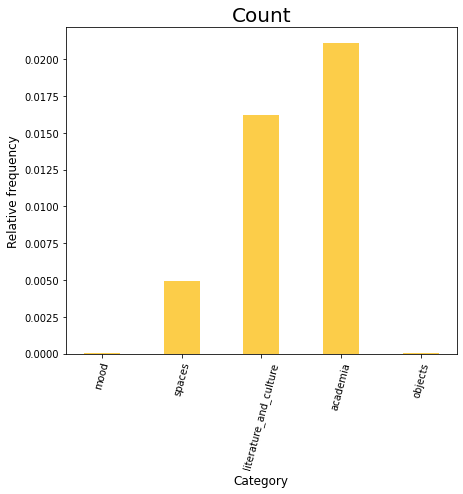

In [20]:
%matplotlib inline

df = pd.read_csv('lexicon.csv')


fig = plt.figure( figsize=( 7 ,6 ) )
ax = plt.axes()

x = 'category'
y = 'count'

bar_width = 0.45
opacity = 0.8

ax.bar( df[x] , df[y] , width = bar_width, alpha = opacity , color = '#fcc11c')

plt.xticks(rotation= 75)

ax.set_xlabel('Category' , fontsize= 12)
ax.set_ylabel('Relative frequency' , fontsize = 12 )
ax.set_title( y.title() , fontsize=20 )


plt.show()

## Words in other domains

In [21]:
selected_domains = [
    
 'psychological_feature',
 'situation',
 'state',
 'location',
 'idea',
 'illumination',
 'natural_object',
 'building',
 'dwelling',
 'housing',
 'physical_phenomenon',
 'natural_phenomenon',
 'educational_institution',
 'social_group',
 'bedroom_furniture',
 'achromatic_color',
 'cognitive_state',
 'psychological_state',
 'condition',
 'emotion',
 'expressive_style',
 'college_student',
 'certificate',
    'color']



In [22]:
data = []

fh = open('secret_history_lemmatised.txt',encoding='utf-8')
full_text = fh.read()
words = word_tokenize(full_text.lower())
words = remove_punctuation(words)
for word in words:
    hypernyms = wordnet_hypernyms(word)
    for h in hypernyms:
        if h in selected_domains:
            row = []
            row.append(word)
            row.append(h)
            data.append(row)
            
domains_df = pd.DataFrame(data,columns=['word','domain'])

In [23]:
domain = 'color'

words = domains_df.query( f'domain == "{domain}"')
words_freq = Counter(list(words['word']))
for word,count in words_freq.most_common(20):
    print(f'{word} ({count})')

black (112)
red (71)
blue (47)
green (34)
yellow (29)
gray (25)
pink (12)
brown (9)
purple (4)
tint (3)
drab (2)
crimson (2)
scarlet (2)
blacks (1)
coral (1)
sepia (1)
amber (1)
pallor (1)
incarnadine (1)
bleach (1)


In [24]:
domain = 'emotion'

words = domains_df.query( f'domain == "{domain}"')
words_freq = Counter(list(words['word']))
for word,count in words_freq.most_common(20):
    print(f'{word} ({count})')

love (65)
horror (22)
alarm (20)
fear (17)
hate (15)
terror (14)
panic (14)
anger (13)
shudder (8)
spite (8)
dread (7)
temper (7)
fit (6)
joy (5)
consternation (5)
thrill (5)
ecstasy (4)
quiver (4)
malice (4)
outrage (4)


In [25]:
domain = 'educational_institution'

words = domains_df.query( f'domain == "{domain}"')
words_freq = Counter(list(words['word']))
for word,count in words_freq.most_common(20):
    print(f'{word} ({count})')

school (134)
lyceum (14)
kindergarten (2)
schools (1)
academy (1)
seminary (1)


# Sentences containing hypernyms

In [26]:
specific_domains = ['emotion']
all_sentences = []

with open('secret_history.txt',encoding='utf') as fh:
    full_text = fh.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = remove_punctuation(words)
        for word in words:
            hypernyms = wordnet_hypernyms(word)
            intersection = list(set(hypernyms) & set(specific_domains))
            if len(intersection) > 0:
                sentence = re.sub('\n',' ',sentence)
                all_sentences.append(sentence.strip())
                break

In [27]:
print(f'The novel contains {len(sentences)} sentences.')
print(f'{len(all_sentences)} sentences were selected.')

for sentence in all_sentences[:15]:
    print(sentence+'\n')

The novel contains 16213 sentences.
230 sentences were selected.
Sunday was a sad day – early to bed, school the next morning, I was constantly worried my homework was wrong – but as I watched the fireworks go off in the night sky, over the floodlit castles of Disneyland, I was consumed by a more general sense of dread, of imprisonment within the dreary round of school and home: circumstances which, to me at least, presented sound empirical argument for gloom.

And if love is a thing held in common, I suppose we had that in common, too, though I realize that might sound odd in light of the story I am about to tell.

This was due to no love for the language but because I was majoring in pre-med (money, you see, was the only way to improve my fortunes, doctors make a lot of money, quod erat demonstrandum) and my counselor had suggested I take a language to fulfill the humanities requirement; and, since the Greek classes happened to meet in the afternoon, I took Greek so I could sleep lat

## Sentiment analysis


In [28]:
def sorted_by_value( dict , ascending = True ):
    if ascending: 
        return {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    else:
        return {k: v for k, v in reversed( sorted(dict.items(), key=lambda item: item[1]))}


In [29]:

sent_scores = dict()

with open('secret_history.txt',encoding='utf-8') as fh:
    full_text = fh.read()
    
    
sentences = sent_tokenize(full_text)

for s in sentences:
    s = re.sub('\s+' , ' ', s)
    scores = ana.polarity_scores(s)
    sent_scores[s] = scores['compound']

nr_sentences = 15
    
print('\nPostive sentences\n')

for s in  sorted_by_value( sent_scores , ascending = False ):
    print( f'{s} [{ sent_scores[s]}]' )
    i+= 1
    if i == nr_sentences:
        break
        
print('\nNegative sentences\n')
i = 0
        
for s in sorted_by_value( sent_scores , ascending = True):
    print( f'{s} [{ sent_scores[s]}]' )
    i+= 1
    if i == nr_sentences:
        break


Postive sentences

– but there is no doubt that Henry was so confident of his own abilities and position in the world, and so comfortable with them, that he had the strange effect of making others (including myself) feel comfortable in their respective, lesser positions, whatever they might happen to be. [0.9768]
While I felt a delicious pleasure in adjusting myself to fit this attractive if inaccurate image – and, eventually, in finding that I had more or less become the character which for a long time I had so skillfully played – there was never any doubt that he did not wish to see us in our entirety, or see us, in fact, in anything other than the magnificent roles he had invented for us: genis grains, corpore glabelliis, arte multiscius, et fortuna opulentus – smooth-cheeked, soft-skinned, welleducated, and rich. [0.9729]
She struck up a conversation, and I could have gone home with her; but it was enough just to flirt, in the tender, uncertain way tragic characters do in films (s

Sciola's expression did not change, but a wisp of smoke curled from his nostrils in a manner subtly indicative of surprise. [0.3919]
'But say we have a certain amount of empirical evidence. [0.3919]
Of course, it was the off season, and not many English around, but for all I know there are entire families of Americans back home in Ohio wondering if… Oh, God. [0.3919]
'But that was going to be the big surprise, you see. [0.3919]
But I wouldn't advise you to go out and buy a copy of Goodbye, Columbus' (required, notoriously, in one of the freshman English classes) 'if you will forgive me for being vulgar.' [0.3919]
I've figured out a rough formula, but still we are talking about a very fine distinction. [0.3898]
'No I don't,' I said, surprised; and, to be honest, the thought hadn't occurred to me. [0.3887]
'Do not fear,' he said to me. [0.3875]
Once it was out of the way I was perfectly comfortable being alone with him even in the most questionable situations – drunk, or in his apartment

Just then the door to his room cracked open. [0.0]
'But you're used to it.' [0.0]
'I do,' I said. [0.0]
'Can't you get by on your own?' [0.0]
'I have to get married.' [0.0]
'So,' he said, blowing out a plume of smoke. [0.0]
I had to light it for him because of his hands. [0.0]
In the most melodramatic way you can possibly imagine.' [0.0]
'And my grandfather found out. [0.0]
His name is Kim.' [0.0]
He went to Harvard. [0.0]
A lawyer. [0.0]
Then he said: 'I was seeing someone. [0.0]
For a moment he didn't answer. [0.0]
'Then why are you going to marry her?' [0.0]
'Because the conversation turns into a vacuum whenever she walks into the room.' [0.0]
'Why is that?' [0.0]
The Black Hole.' [0.0]
Do you know what my cousins call her? [0.0]
'She's stupid,' said Francis passionately. [0.0]
Blue-eyed blonde, tastefully clad, built along the Marion line. [0.0]
But then he pushed up in his bed a bit and riffled through his night table and found a photograph of her, which he showed to me. [0.0]
he 

I sat up, turned on the lights; my mouth was stained a ghastly blue. [0.0]
All I knew about autopsies was what I had seen on reruns of'Quincy,' but somehow it never occurred to me that my information might be inaccurate because it came from a TV show. [0.0]
When the snow finally melted it went as quickly as it had come. [0.0]
He did touch people's lives, the lives of strangers, in an entirely unanticipated way. [0.0]
'He touched people's lives,' said the college president, leaning forward to grip the podium with both his hands; and though he was to repeat the exact phrase, in the exact way, two months later at a memorial service for the freshman girl (who'd fared better with a singleedged razor blade than with the poison berries), it was, in Bunny's case at least, strangely true. [0.0]
He paused, watching a girl with a tambourine twirling dizzily on the lawn. [0.0]
Tantrism acted as a kind of corrupting influence upon the Indian Buddhist pantheon, though of course elements of it were a

He must have laid it out while I was asleep. [0.0]
I filled my glass again and took it to the living room with me and sat on the couch. [0.0]
It was seven a. m. by the kitchen clock. [0.0]
I went to the kitchen, my footsteps echoing in the silence, and drank a glass of water standing at the sink. [0.0]
I was thirsty. [0.0]
I stared at the overflowing ashtray, the three-quarters-empty bottle of Famous Grouse, the game of poker solitaire laid out upon the table. [0.0]
I sat up and rubbed the waffled pattern the sofa cushion had left on my cheek. [0.0]
'I can get us out of it, I think. [0.0]
he said, and lit a cigarette. [0.0]
He pushed the deck over to me. [0.0]
I blinked at him. [0.0]
'It's early still. [0.0]
He turned unsteadily, loosening his tie as he did it, and swayed out of the room. [0.0]
He stood up unsteadily and pulled with his forefinger at his collar. [0.0]
'What are you going to do?' [0.0]
But still. [0.0]
Music from a neighbor's stereo was filtering through the walls. [0.0

Then Charles said, in a loud, clear voice: 'Henry, why do I think for some reason that this is all your fault?' [-0.0258]
,' can't stand this, I thought, I've got to leave, but still Henry talked, and still I stood there, and the sicker and blacker I felt to hear Henry's voice and to see the look on Julian's face. [-0.0258]
Seeing her was like an electric shock. [-0.0258]
There were rapid footsteps on the linoleum and henlike clucks and cries of greeting. [-0.0258]
'He seems pretty sick. [-0.0258]
Henry should know better than to antagonize him after the other night.' [-0.0258]
He used to be crazy about her, I'm sure you know that; for all I know he still is. [-0.0258]
My head ached and my feet were like lead. [-0.0258]
He shook a cigarette from a pack of Lucky Strikes that Henry had left on the counter. [-0.0258]
Then, with terrible composure, he stepped back and absently dragged the hand across his chest, smearing mud upon his lapel, his tie, the starched immaculate white of his shir

'I am sick of talking about this.' [-0.5106]
'I remember when you used to say how ugly they were. [-0.5106]
'I know this is an imposition on a school night, but I really don't think it's wise for any of the rest of us to go back again. [-0.5157]
Out of sheer desperation I took a handful, also two ambiguous capsules that had a Drowsiness sticker but which I suspected of being antihistamines. [-0.5187]
The doctors couldn't figure out quite what was wrong with Charles. [-0.5209]
If what Bunny really wanted was revenge, he could have had it easily enough and without putting himself at risk. [-0.5209]
'Last night I was so upset I could hardly sleep,' he said. [-0.5214]
I was so upset that it took me a moment to realize it was only Charles. [-0.5214]
'Don't you just love him? [-0.5216]
'And she's an elementaryeducation major, too, don't you love it?' [-0.5216]
It seemed impossible then that one could ever be angry at him, no matter what he did. [-0.5226]
It's just that Charles was so much wo

In [30]:
word_freq = Counter(word_tokenize(full_text))

nr_words = 50
i=0 
for word,count in word_freq.most_common():
    scores = ana.polarity_scores(word)

    if scores['compound'] > 0.5:
        print(f'{word} ({count}) - sentiment score {scores["compound"]}')
        i+= 1
        if i==nr_words:
            break

kind (124) - sentiment score 0.5267
great (64) - sentiment score 0.6249
heart (46) - sentiment score 0.6369
best (46) - sentiment score 0.6369
love (38) - sentiment score 0.6369
smiled (36) - sentiment score 0.5423
happy (34) - sentiment score 0.5719
beautiful (34) - sentiment score 0.5994
strong (29) - sentiment score 0.5106
perfectly (27) - sentiment score 0.6369
lovely (21) - sentiment score 0.5859
laugh (21) - sentiment score 0.5574
loved (18) - sentiment score 0.5994
pleasant (18) - sentiment score 0.5106
rich (17) - sentiment score 0.5574
fun (17) - sentiment score 0.5106
beauty (14) - sentiment score 0.5859
wonderful (14) - sentiment score 0.5719
free (14) - sentiment score 0.5106
excellent (14) - sentiment score 0.5719
glorious (13) - sentiment score 0.6369
charming (11) - sentiment score 0.5859
pleasure (11) - sentiment score 0.5719
comfortable (11) - sentiment score 0.5106
trust (10) - sentiment score 0.5106
brilliant (9) - sentiment score 0.5859
marvelous (8) - sentiment sco

In [31]:
nr_words = 50
i=0 
for word,count in word_freq.most_common():
    scores = ana.polarity_scores(word)

    if scores['compound'] < -0.5:
        print(f'{word} ({count}) - sentiment score {scores["compound"]}')
        i+= 1
        if i==nr_words:
            break

bad (100) - sentiment score -0.5423
dead (68) - sentiment score -0.6486
sick (60) - sentiment score -0.5106
death (48) - sentiment score -0.5994
lying (34) - sentiment score -0.5267
hell (31) - sentiment score -0.6808
killed (27) - sentiment score -0.6705
died (26) - sentiment score -0.5574
horrible (26) - sentiment score -0.5423
angry (25) - sentiment score -0.5106
murder (22) - sentiment score -0.6908
horror (22) - sentiment score -0.5719
kill (21) - sentiment score -0.6908
shit (20) - sentiment score -0.5574
hurt (20) - sentiment score -0.5267
poison (16) - sentiment score -0.5423
die (16) - sentiment score -0.5994
hate (15) - sentiment score -0.5719
terror (14) - sentiment score -0.5267
stupid (14) - sentiment score -0.5267
failed (13) - sentiment score -0.5106
pain (13) - sentiment score -0.5106
nasty (13) - sentiment score -0.5574
panic (13) - sentiment score -0.5106
ugly (12) - sentiment score -0.5106
terribly (12) - sentiment score -0.5574
worst (12) - sentiment score -0.6249
e

## Named entity recognition

In [ ]:
    
import stanza

selected_types = ['GPE','WORK_OF_ART','ORG','PERSON']

all_named_enities = []
ne_tag = dict()

nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

sentences = sent_tokenize(full_text)

for s in tqdm(sentences):

    doc = nlp(s)
    for ne in doc.ents:
        if ne.to_dict()['type'] in selected_types:
            all_named_enities.append(ne.to_dict()['text'])
            ne_tag[ne.to_dict()['text']] = ne.to_dict()['type']




2025-12-09 14:19:11 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2025-12-09 14:19:11 INFO: Use device: cpu
2025-12-09 14:19:11 INFO: Loading: tokenize
2025-12-09 14:19:11 INFO: Loading: ner
2025-12-09 14:19:12 INFO: Done loading processors!
 30%|███████████▍                          | 4893/16213 [11:19<13:26, 14.04it/s]

In [ ]:
ne_freq = Counter(all_named_enities)

max_nr = 50
i = 0

for ne,count in ne_freq.most_common(100):
    if ne_tag[ne] == 'WORK_OF_ART':
        print(f"{ne} ({count})")
        i += 1
        if i == max_nr:
            break
    

In [ ]:

max_nr = 50
i = 0

for ne,count in ne_freq.most_common(100):
    if ne_tag[ne] == 'GPE':
        print(f"{ne} ({count})")
        i += 1
        if i == max_nr:
            break